In this homework, you need to solve four tasks. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`). Overall, there are 23 points, however, you can get a maximum of 20 points for this assignment( `your_points = min(your_points, 20)`). No bonus points will be transferred to the next assignment.

# Task 1. Non-parametric Density Estimation (6 points)

In [1]:
import numpy as np
import numpy.linalg as nla
import scipy
import scipy.stats
import pandas as pd

from statsmodels.nonparametric.kernel_regression import KernelReg

In [2]:
# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# non-interactive
%matplotlib inline

#jupyterlab
# %matplotlib widget 

#jupyter-notebook
# %matplotlib notebook 

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

You will work with data sampled from the mixture of Normal distributions:

In [3]:
seed1 = 31337
seed2 = 42
n_samples = 100

f1 = scipy.stats.norm(loc=0, scale=1)
f2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1

Xa = f1.rvs(size=int(p1 * n_samples), random_state=seed1)
Xb = f2.rvs(size=int(p2 * n_samples), random_state=seed2)
samples = np.concatenate([Xa, Xb])

a = -5
b = 10

x_values = np.linspace(a, b, 1000)
binedges = np.linspace(a, b, 10)
true_pdf = p1 * f1.pdf(x_values) + p2 * f2.pdf(x_values)

## Histogram estimate

$\newcommand{\boldX}{\boldsymbol{X}}$
$\newcommand{\xs}[1]{\boldX^{(#1)}}$
$\newcommand{\Sum}{\sum\limits}$
$\newcommand{\Int}{\int\limits}$
$\newcommand{\hatp}{\widehat{p}}$
$\newcommand{\hatJ}{\widehat{J}}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$

Given a sample $\boldsymbol{X}^{(n)} = \boldsymbol{X}_1, \boldsymbol{X}_2, ..., \boldsymbol{X}_n \sim \; iid \; p(x)$ we would like to build a hitogram estimate of the density. If we have $m$ bins of size $h$, we can have the following estimates of risk using leave-one-out cross validation:

\begin{gather*}
J(h) = \int \hatp^2\lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx, 
\end{gather*}
\begin{gather*}
\hatJ(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - \frac{2}{n}\Sum_{i = 1}^n \hatp \lp \boldsymbol{X}_i ;\xs{n\backslash i} \rp, \label{eq1}\tag{1}
\end{gather*}
\begin{gather*}
\hatJ(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\Sum_{i = 1}^m \hatp_j^2,\quad \hatp_j = \frac{n_j}{n}. \label{eq2}\tag{2}
\end{gather*}

Your task is:
1. Build a histogram estimate of the pdf given the sample above, tune bandwidth using leave-one-out CV. Use formula (\ref{eq2}). Also check out `np.histogram` (1 point)
2.\* Prove that for histograms (\ref{eq2}) follows from (\ref{eq1}) (1 bonus point)
3. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$ (0.5 point)
4. Recall the approximation to $MISE$ from Lecture 7, slides 11-13. Assume an Oracle calculated the integral of the squared derivative of the true density for you and the value is $0.0804924$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)
5. `np.histogram` has some built-in methods of selecting bandwidth. Compare some of them with your result and theoretical approximation (again, using CV estimate of $J$) (1 point)

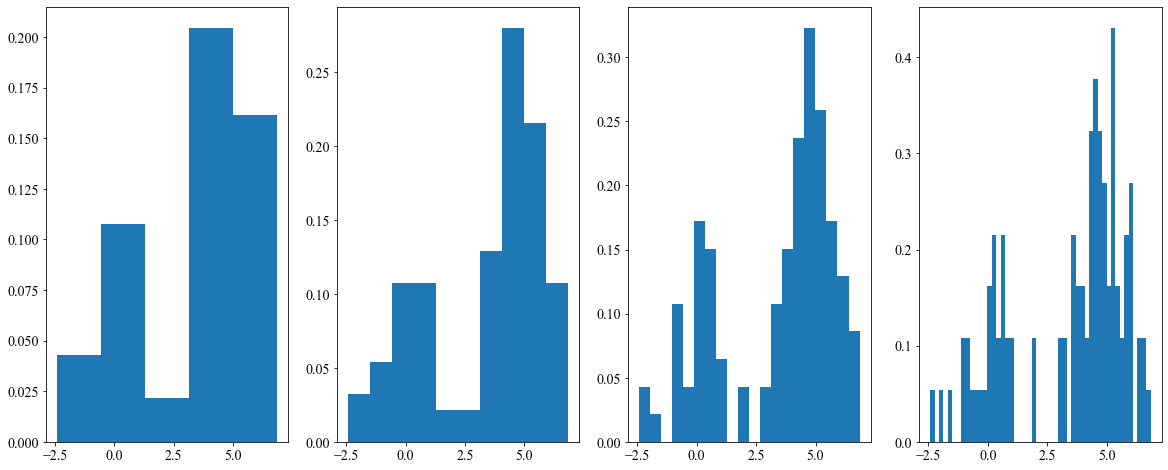

In [4]:
sample_min, sample_max = np.min(samples), np.max(samples)
delta = sample_max - sample_min

bin_list = [5, 10, 20, 50]
fig, axes = plt.subplots(1, len(bin_list), figsize=(20, 8))
for ax, bins in zip(axes, bin_list):
    ax.hist(samples, bins=bins, density=True)
    h = delta / bins / 3

For the formula (1):

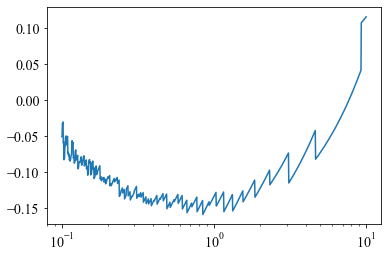

In [5]:
def cross_validation_histogram(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h))
    h_eff = (sample_max - sample_min) / bins
    mask = np.ones(n, dtype=np.bool_)
    summ = 0
    for i in range(n):
        mask[i] = False
        p = np.histogram(sample[mask], bins=bins, range=(sample_min, sample_max), density=True)[0]
        mask[i] = True
        index = np.int((sample[i] - sample_min) / h_eff)
        if index > 0 and index < len(p):   
            summ += p[index]
    summ = 2 * summ / n
    
    p = np.histogram(sample, bins=bins, range=(sample_min, sample_max), density=True)[0]
    summ2 = np.sum(p**2) * h
    return summ2 - summ

h_list = np.logspace(-1, 1, 1000)
cv_hist = [cross_validation_histogram(samples, hi) for hi in h_list]
plt.plot(h_list, cv_hist)
plt.xscale("log");

In [6]:
h_cv = h_list[np.argmin(cv_hist)]
h_cv

0.8451366330684718

In [7]:
J_cv = cross_validation_histogram(samples, h_cv)
J_cv

-0.15885126764706217

For the formula (2):

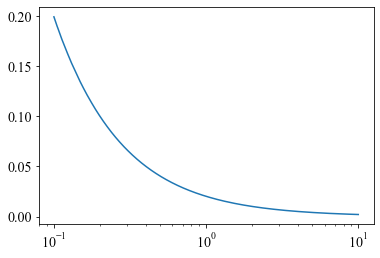

In [8]:
def cross_validation_histogram(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h))
    summ = 0
    for i in range(bins):
        count, edges = np.histogram(sample, bins=bins, range=(sample_min, sample_max), density=True)
        summ += (count[i]/n)*(count[i]/n)
    final_summ = 2/((n-1)*h) - (summ*(n+1))/((n-1)*h)
    return final_summ

h_list = np.logspace(-1, 1, 1000)
cv_hist = [cross_validation_histogram(samples, hi) for hi in h_list]
plt.plot(h_list, cv_hist)
plt.xscale("log");

In [9]:
h_cv = h_list[np.argmin(cv_hist)]
h_cv

10.0

In [10]:
J_cv = cross_validation_histogram(samples, h_cv)
J_cv

0.0020200836191097095

In [11]:
np.histogram(samples, bins=30, range=(sample_min, sample_max), density=True)

(array([0.03231886, 0.03231886, 0.03231886, 0.        , 0.06463772,
        0.09695658, 0.03231886, 0.12927544, 0.16159429, 0.06463772,
        0.25855087, 0.        , 0.        , 0.03231886, 0.03231886,
        0.        , 0.        , 0.06463772, 0.06463772, 0.12927544,
        0.19391315, 0.16159429, 0.32318859, 0.35550745, 0.19391315,
        0.29086973, 0.16159429, 0.16159429, 0.09695658, 0.06463772]),
 array([-2.43022774, -2.12081088, -1.81139401, -1.50197715, -1.19256028,
        -0.88314342, -0.57372656, -0.26430969,  0.04510717,  0.35452404,
         0.6639409 ,  0.97335777,  1.28277463,  1.59219149,  1.90160836,
         2.21102522,  2.52044209,  2.82985895,  3.13927581,  3.44869268,
         3.75810954,  4.06752641,  4.37694327,  4.68636014,  4.995777  ,
         5.30519386,  5.61461073,  5.92402759,  6.23344446,  6.54286132,
         6.85227818]))

In [12]:
np.histogram(samples, bins='auto', range=(sample_min, sample_max))

(array([ 3,  7, 18,  2,  4, 21, 31, 14], dtype=int64),
 array([-2.43022774, -1.2699145 , -0.10960126,  1.05071198,  2.21102522,
         3.37133846,  4.5316517 ,  5.69196494,  6.85227818]))

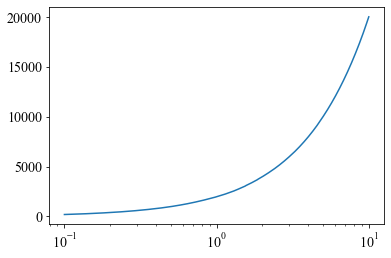

In [13]:
def cross_validation_histogram(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h))
    h_eff = (sample_max - sample_min) / bins
    mask = np.ones(n, dtype=np.bool_)
    summ = 0
    for i in range(n):
        mask[i] = False
        p = np.histogram(samples, bins='auto', range=(sample_min, sample_max))[0]
        mask[i] = True
        index = np.int((sample[i] - sample_min) / h_eff)
        if index > 0 and index < len(p):   
            summ += p[index]
    summ = 2 * summ / n
    
    p = np.histogram(samples, bins='auto', range=(sample_min, sample_max))[0]
    summ2 = np.sum(p**2) * h
    return summ2 - summ

h_list = np.logspace(-1, 1, 1000)
cv_hist = [cross_validation_histogram(samples, hi) for hi in h_list]
plt.plot(h_list, cv_hist)
plt.xscale("log");

In [14]:
h_cv = h_list[np.argmin(cv_hist)]
h_cv

0.1

In [15]:
J_cv = cross_validation_histogram(samples, h_cv)
J_cv

199.92

## Kernel density estimate

In this part, you will use the same sample, but employ the kernel density estimation method. We can use the same proxy expression to optimise the risk:
\begin{gather*}
J(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx
\end{gather*}

In out case of kernel estimator, we can obtain:
\begin{gather*}
\hatJ(h) = \frac{1}{hn^2}\Sum_{i = 1}^n\Sum_{j = 1}^n K^{(2)}\lp\frac{x_i - x_j}{h}\rp + \frac{2K(0)}{nh}, \label{eq3}\tag{3}
\end{gather*}
where
\begin{gather*}
K^{(2)}(x) = K^*(x) - 2K(x), \quad K^*(x) = \int K(x - y) K(y) dy.
\end{gather*}

You can use [kernel density estimation from sklearn](http://scikit-learn.org/stable/modules/density.html). Your task is:
1. Build a kernel density estimate given the sample from before, tune bandwidth using leave-one-out CV. Try two different kernels of your choice. Use formula \ref{eq3} for your estimates (1 point)
2. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$. What kernel worked better in terms of estimated risk? (0.5 point)
3. Recall the approximation to $MISE$ from Lecture 7, slide 20. Assume an Oracle calculated the integral of the squared second derivative of the true density for you and the value is $0.127529$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)

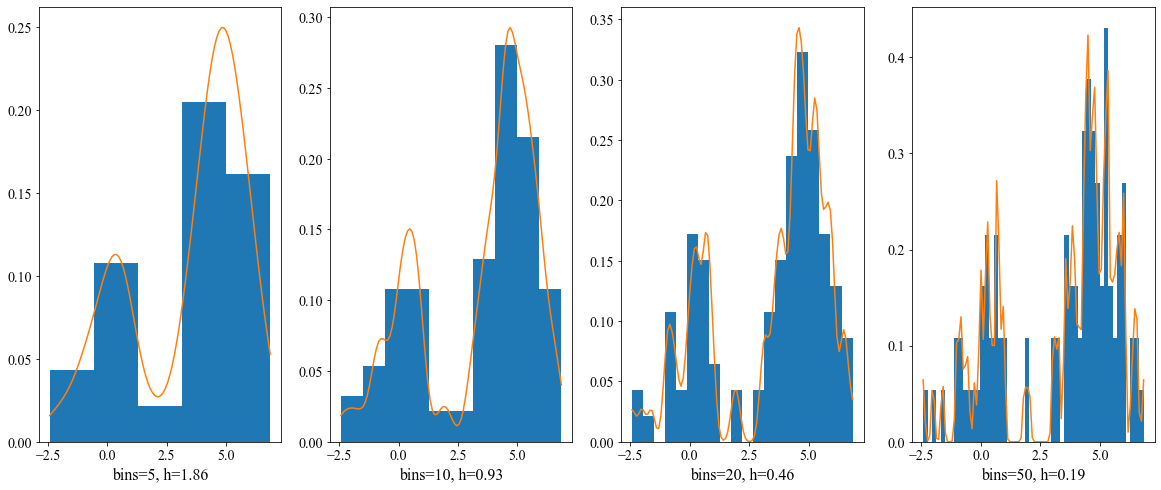

In [16]:
from sklearn.neighbors import KernelDensity
grid = np.linspace(sample_min, sample_max, 100)
bin_list = [5, 10, 20, 50]
fig, axes = plt.subplots(1, len(bin_list), figsize=(20, 8))
for ax, bins in zip(axes, bin_list):
    
    ax.hist(samples, bins=bins, density=True)
    
    h = delta / bins / 3
    density = KernelDensity(kernel="gaussian", bandwidth=h).fit(samples[:, None])
    ax.plot(grid, np.exp(density.score_samples(grid[:, None])))
    ax.set_xlabel(f"bins={bins}, h={delta / bins:.2f}")

In [17]:
def cross_validation_kernel(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h))
    mask = np.ones(n, dtype=np.bool_)
    summ = 0
    sample = sample[:, None]
    for i in range(n):
        mask[i] = False
        p = KernelDensity(kernel="gaussian", bandwidth=h).fit(sample[mask])
        mask[i] = True
        summ += np.exp(p.score_samples(sample[i].reshape(1, 1)))
    summ = 2 * summ / n
    
    p = KernelDensity(kernel="gaussian", bandwidth=h).fit(sample[mask]).score_samples(np.linspace(sample_min, sample_max, 101)[:, None])
    p /= p.sum()
    
    summ2 = np.sum(p**2) / h
    return (summ2 - summ).item()

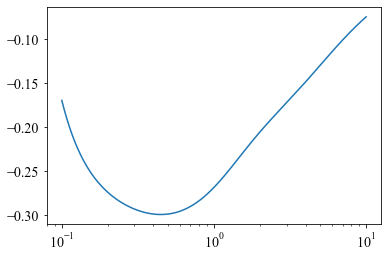

In [18]:
h_list = np.logspace(-1, 1, 1000)
cv_hist = [cross_validation_kernel(samples, hi) for hi in h_list]
plt.plot(h_list, cv_hist)
plt.xscale("log")

In [19]:
h_cvk = h_list[np.argmin(cv_hist)]
h_cvk

0.44735330544984653

In [20]:
J_cvk = cross_validation_kernel(samples, h_cvk)
J_cvk

-0.2992931073817056

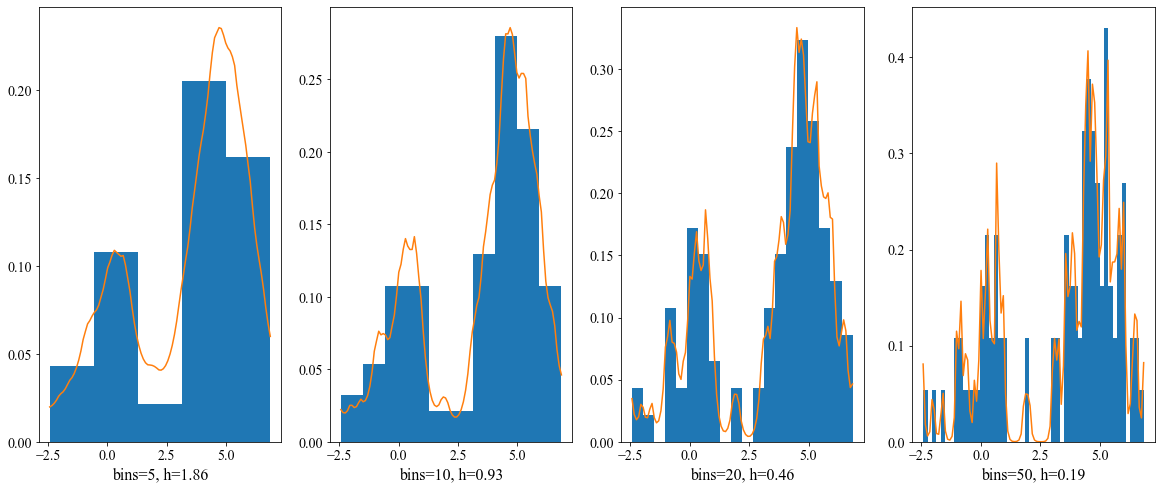

In [21]:
bin_list = [5, 10, 20, 50]
fig, axes = plt.subplots(1, len(bin_list), figsize=(20, 8))
for ax, bins in zip(axes, bin_list):
    
    ax.hist(samples, bins=bins, density=True)
    
    h = delta / bins / 3
    density = KernelDensity(kernel="exponential", bandwidth=h).fit(samples[:, None])
    ax.plot(grid, np.exp(density.score_samples(grid[:, None])))
    ax.set_xlabel(f"bins={bins}, h={delta / bins:.2f}")

In [22]:
def cross_validation_kernel(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h))
    mask = np.ones(n, dtype=np.bool_)
    summ = 0
    sample = sample[:, None]
    for i in range(n):
        mask[i] = False
        p = KernelDensity(kernel="exponential", bandwidth=h).fit(sample[mask])
        mask[i] = True
        summ += np.exp(p.score_samples(sample[i].reshape(1, 1)))
    summ = 2 * summ / n
    
    p = KernelDensity(kernel="exponential", bandwidth=h).fit(sample[mask]).score_samples(np.linspace(sample_min, sample_max, 101)[:, None])
    p /= p.sum()
    
    summ2 = np.sum(p**2) / h
    return (summ2 - summ).item()

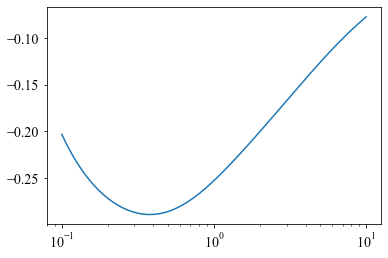

In [23]:
h_list = np.logspace(-1, 1, 1000)
cv_hist = [cross_validation_kernel(samples, hi) for hi in h_list]
plt.plot(h_list, cv_hist)
plt.xscale("log")

In [24]:
h_cvk = h_list[np.argmin(cv_hist)]
h_cvk

0.37894709190746667

In [25]:
J_cvk = cross_validation_kernel(samples, h_cvk)
J_cvk

-0.2890298331863149

Exponential Kernel seems better in terms of estimated risk.

# Task 2. Non-parametric Regression (5.5 pt)

In this task you will apply non-parametric regression to airport statistics data.

### Data loading and preprocessing

Load dataset from `airport_operations_report.csv`. Use `General Aviation: Total Operations` as target(dependent) variable and `[Air Carrier Operations, General Aviation: Local Operations]` as covariates(independent variables). Divide $1^{st}$ covariate by `1000`, $2^{nd}$ by `100` and target by `1000`. Make 2D grid for covariates from minimum to maximum values with `100` steps along each dimension.

In [26]:
df = pd.read_csv("airport_operations_report.csv", sep=",")

target = df["General Aviation: Total Operations"].values/1000
sample1 = df["Air Carrier Operations"].values/1000
sample2 = df["General Aviation: Local Operations"].values/100
sample = np.stack((sample1, sample2)).T

In [27]:
sample1_min, sample1_max = np.min(sample1), np.max(sample1)
sample2_min, sample2_max = np.min(sample2), np.max(sample2)
sample_min = np.stack((sample1_min, sample2_min)).T
sample_max = np.stack((sample1_max, sample2_max)).T

delta1 = sample1_max - sample1_min
delta2 = sample2_max - sample2_min

grid1 = np.linspace(sample1_min, sample1_max, 100)
grid2 = np.linspace(sample2_min, sample2_max, 100)
xx, yy = np.meshgrid(grid1, grid2)
grid = np.stack([xx, yy], axis=2).reshape(-1,2)

### Fit model (1 pt)

Perform a nonparametric regression to fit the model $Y = f(x)+\varepsilon$. 

In [28]:
nw = KernelReg(target, sample, var_type="oo", reg_type="lc")

C:\Users\Kundyz Onlabek\anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:102: RuntimeWarning: invalid value encountered in power
  kernel_value = 0.5 * (1 - h) * (h ** abs(Xi - x))
C:\Users\Kundyz Onlabek\anaconda3\lib\site-packages\scipy\optimize\optimize.py:708: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[0]:
C:\Users\Kundyz Onlabek\anaconda3\lib\site-packages\scipy\optimize\optimize.py:719: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-2]:
C:\Users\Kundyz Onlabek\anaconda3\lib\site-packages\scipy\optimize\optimize.py:724: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-1]:
C:\Users\Kundyz Onlabek\anaconda3\lib\site-packages\scipy\optimize\optimize.py:712: RuntimeWarning: invalid value encountered in less
  if fxe < fxr:


Predict values for created grid.

In [29]:
target_pred, margins = nw.fit(grid)
target_pred = target_pred.reshape(100, 100)
grid = grid.reshape(100, 100, 2)

This is function to visualize 3D surfaces. You can modify it if you need.

In [30]:
def plot_surface_function(x1, x2, y, minmax_values=None, ax=None):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')

        surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.5, edgecolor="k")
        if minmax_values is not None:
            ax.set_xlim3d(*minmax_values[0])
            ax.set_ylim3d(*minmax_values[1])
    
    else:
        surf = ax.plot_surface(x1, x2, y, cmap=cm.bwr, linewidth=0.5, alpha=0.1, edgecolor="k")
        
    return ax

Let's plot estimated surface.

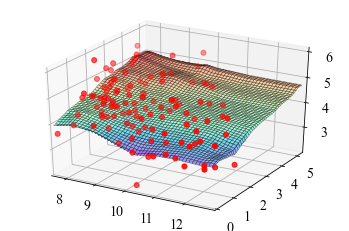

In [31]:
# target - dependent variable
# grid - grid for covariates
# sample - covariates

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((sample_min, sample_max)).T)
ax.scatter(sample[:, 0], sample[:, 1], target, marker="o", s=25, c="r");

### Estimate confidence intervals (2 pt)

Construct 95\% confidence bands for your estimate. To estimate error variance for 1D covariate, you sort your sample and subtract target values in the nearest points. For 2D covariate, you should, for each point, calculate the difference in target values between a point and its nearest neighbor(in euclidian metric). To get power for quantile of standard normal distribution, which is $\frac{w}{b-a}$ for 1D, estimate it per coordinate and multiply: $\prod_{i=1}^2 \frac{w_i}{b_i-a_i}$. 

In [32]:
#def prediction_se(grid, sample, target, h, alpha=0.05):

    # Your code here

In [33]:
# Your code here

#qse = prediction_se(...)
#qse = qse.reshape(*step_numbers)

Let's plot confidence intervals

In [34]:
#ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((sample_min, sample_max)).T)
#ax.scatter(sample[:, 0], sample[:, 1], target, marker="o", s=25, c="r")
#ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred + qse, ax=ax)
#ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred - qse, ax=ax)

### Find optimal bandwidth (2 pt)

Use cross-validation to estimate the bandwidth.

In [35]:
#def cross_validation_regression(sample, target, h):

    # Your code here

Make grid with logarithm step to find best bandwidth, from `0.1` to `10` with `21` steps along each dimension. Visualize obrained results with `plot_surface_function`. Print values for optimal bandwidth.

In [36]:
# Your code here



Plot surface with estimated bandwidth.

In [37]:
# Your code here



### Conclusion (0.5 pt)

Write your conclusions about conducted experiments (2-5 sentence).

    Your conclusion here ...

# Task 3. Model Selection (5.5 pt)

In this task you will select model(choose set of covariates) using AIC criteria and forward/backward stepwise regression.

### Data loading and preprocessing

Read dataset `pacn_wrcc.csv`. The target variable is `ly Solar Rad.`, others are covariates.

In [38]:
df = pd.read_csv("pacn_wrcc.csv", sep=",")

target = df["ly Solar Rad."]
sample = df.drop(columns = ['ly Solar Rad.'], axis=1)
sample['randNumCol'] = np.random.randint(1, 6, sample.shape[0])

Scale covariates to range `[0, 1]` and add bias column.

In [39]:
starget = (target-min(target))/(max(target)-min(target))

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ssample = scaler.fit_transform(sample)

### AIC and sample variance (2 pt) 

Estimate sample variance of error with full set of covariates. Take into account number of dependent variables.

In [41]:
ssample_transpose = ssample.transpose ()
a = ssample_transpose.dot(ssample)
b = np.linalg.inv(a)
c = b.dot(ssample_transpose)
d = c.dot(starget)
e = ssample.dot(d)
residual = e - starget
sigma2 = residual/(14-2)

Implement estimate of AIC for given covariates, target and error variance.

In [42]:
def aic(X, y, sigma2):
    n = X.shape[1]
    k = X.shape[1] + 1
    ll = -(n * 1/2) * (1 + np.log(2 * np.pi)) - (n / 2) * np.log(sigma2.dot(sigma2) / n)
    AIC = (-2 * ll) + (2 * k)
    return AIC
aic(ssample, starget, sigma2)

-30.943435164264763

### Forward stepwise regression (1 pt)

Implement forward stepwise regression. Save the order in which covariates are added to feature set and AIC values for those feature sets.

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

features = sample.values
consider = []
i=1
for col in features:
        i+=1
        log_regressor = linear_model.LinearRegression()
        score2 = cross_val_score(log_regressor,ssample,starget,cv=5)
        print ("lin_reg: mean="+str(np.mean(score2))+" std="+str(np.std(score2)))
        np.mean(score2)

lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.887124301913339

lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.8871243019133399 std=0.03863996642187592
lin_reg: mean=0.887124301913339

In [44]:
def forward_stepwise_regression(X, y, sigma2, alpha=0.):
    
    # Your code


SyntaxError: unexpected EOF while parsing (<ipython-input-44-21d9a0ef0828>, line 3)

In [ ]:
features, aic_list = forward_stepwise_regression(X, y, sigma2, alpha)
for a, aic_value in enumerate(aic_list, 1):
    print(f"AIC {aic_value:.3f} +{features[:a]}")

### Backward stepwise regression (1 pt)

Implement backward stepwise regression. Save the order in which covariates are removed from feature set and AIC values for those feature sets.

In [ ]:
def backward_stepwise_regression(X, y, sigma2, alpha=0.):
    
    # Your code


In [ ]:
features, aic_list = backward_stepwise_regression(X, y, sigma2, alpha)
for a, aic_value in enumerate(aic_list, 1):
    print(f"AIC {aic_value:.3f} -{features[:a]}")

### Bruteforce (1 pt)

Find best sets of covariates and their AIC for all sizes of feature sets.

In [ ]:
def bruteforce(X, y, sigma2, alpha=0.):
    
    # Your code


In [ ]:
features, aic_list = bruteforce(X, y, sigma2, alpha)
for a, aic_value in enumerate(aic_list):
    print(f"AIC {aic_value:.3f} -{features[a]}")

### Conclusion (0.5 pt)

Write your conclusions about conducted experiments (2-5 sentence).

    Your conclusion here ...

# Task 4. Local regression (6 points)

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LogisticRegression

In [ ]:
X = np.array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18181818,
        1.24242424,  1.3030303 ,  1.36363636,  1.42424242,  1.48484848,
        1.54545455,  1.60606061,  1.66666667,  1.72727273,  1.78787879,
        1.84848485,  1.90909091,  1.96969697,  2.03030303,  2.09090909,
        2.15151515,  2.21212121,  2.27272727,  2.33333333,  2.39393939,
        2.45454545,  2.51515152,  2.57575758,  2.63636364,  2.6969697 ,
        2.75757576,  2.81818182,  2.87878788,  2.93939394,  3.        ])

In [ ]:
Y = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

You are given a sample of pairs $(X_i, Y_i)$. The output variable appers to be binary. We know a model for this type of data: logistic regression. In this model we assume the log-odds of the Bernoulli output variable to be a linear function:
$$\mathbb{P}(Y_i = 1 | X_i = x_i) = p(x_i) = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$$
Lets fit a standard logistic regression to the data:

In [ ]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

In [ ]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.legend()

## Local regression

As we can see, the dependence of the outcome on $x$ looks more complex than estimated using logistic regression. We will try to improve it with local regression methods instead.
Instead of a global model, we will approximate conditinal probability of the positive class in a neighbourhood of $x$ with:
$$p(u) \approx \frac{e^{\beta_0 + \beta_1 (u-x) }}{1 + e^{\beta_0 + \beta_1 (u-x)}}, $$
for $u$ close to $x$. The coefficients in this case will depend on $x$. To find them, we will have to fit a (slightly different) model at each new query point $x_{new}$ (point where we want to predict $Y$). We will also need to introduce a notion of 'closenes' of points across $x$ - for this we can use our familiar *kernel functions*. Bringing everything together, we introduce the following local loglikelihood for our proposed model:
$$\ell_x(\beta) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right)\ell\left(Y_i, \beta_0 + \beta_1 \left(X_i - x\right)\right) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right) \left(Y_i \left(\beta_0 + \beta_1 \left(X_i - x\right)\right) - \log \left( 1 + e^{\beta_0 + \beta_1 \left(X_i - x\right)} \right) \right),$$
$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$
Here $\ell(y, z)$ is a log-likelohood for a single Bernoulli with log-dds ratio $z = \frac{p}{1-p}$. The local log-likelihood $\ell_x(\beta)$ should be optimized numerically to each new point $x$ to obtain $\widehat{\beta}(x)=(\widehat{\beta_0}(x), \widehat{\beta_1}(x))$. Then, we can predict $Y$ using the logistic model:
$$ \mathbb{P}(Y=1 | X=x) = \frac{e^{\beta_0(x)}}{1 + e^{\beta_0(x)}}.$$
Your task is:
1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package (2 points)
2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample (3 points)
3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth (1 bonus point)

In [ ]:
# Your code for Local Logistic regression

In [ ]:
# Your code for Local Linear regression